# AirQo Ugandan Air Quality Forecast Challenge

Until recently there has been a lack of data on air quality across sub-Saharan Africa. Reference grade monitors are extremely expensive and without access to data it is very difficult to raise awareness of the issues, or for government, business and individuals to know which actions to take to improve air quality and protect community health.

[AirQo](https://www.airqo.net/) has built a low-cost network of sensors and collected data across 65 locations in Uganda with some sites monitoring for over three years. The increase in availability of air quality data allows us to analyse historical and up to the minute results to gain insights into trends, hotspots, causes and consequences of poor air, potential policy solutions and so much more.

The ability to accurately predict what air quality will be in the coming days is also essential for empowering everyone from governments to families to make informed decisions to protect health and guide action, just as we do with weather.

In [1]:
#!pip install catboost

In [20]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm
import xgboost as xgb
import catboost
import os
import gc

import warnings
warnings.filterwarnings('ignore')

## Data Loading and EDA

In [2]:
train = pd.read_csv("./raw/Train.csv")
test = pd.read_csv("./raw/Test.csv")
meta = pd.read_csv("./raw/airqo_metadata.csv")

In [4]:
#print(len(train.iloc[1][2]))
train.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press,target
0,ID_train_0,C,"nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...",45.126304
1,ID_train_1,D,"22.53333333,21.71666667,20.83333333,20.9833333...","0.102,0.0,0.0,0.0,0.0,0.0,0.0,0.034,0.017,0.01...","0.744583333,0.808083333,0.911166667,0.91633333...","281.6643101,89.15629262,81.96853891,291.018632...","2.3775,1.126666667,0.700833333,0.3416666670000...","90.32,90.3775,90.44083333,90.4725,90.45416667,...",79.131702
2,ID_train_10,A,"28.975,27.95,29.6,26.425,22.09166667,21.775,22...","0.0,0.0,0.0,0.102,0.136,0.0,0.0,2.16,1.276,0.0...","0.573333333,0.597166667,0.5668333329999999,0.6...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na...","88.55166667,88.46416667,88.31916667,88.24,88.2...",32.661304
3,ID_train_100,A,"22.96666667,24.26666667,25.275,25.625,25.86666...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.77,3.012,1.0...","0.8430833329999999,0.79025,0.7375,0.728,0.7049...","300.0850574,293.6769595,294.5174647,301.921416...","1.446666667,1.1925,1.324166667,1.5441666669999...","88.615,88.53083333,88.4,88.27166667,88.2075,88...",53.850238
4,ID_train_1000,A,"21.875,21.575,21.525,21.43333333,20.50833333,1...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.8564166670000001,0.874916667,0.879833333,0.8...","21.83997432,17.05405341,89.26406044,123.585424...","0.1975,0.244166667,0.411666667,0.56,0.5775,0.4...","88.55666667,88.64083333,88.65833333,88.6475,88...",177.418750


In [56]:
#print(max(train.target))
sliced_meta = meta.iloc[:,1:5] 
sliced_meta.head()

,location,loc_altitude,km2,aspect
0,A,1122.4,1.9,194.0
1,B,1155.4,5.4,219.8
2,C,1178.3,8.5,168.7
3,D,980.8,0.8,90.0
4,E,1186.5,1.6,121.0


In [3]:
test.head()

,ID,location,temp,precip,rel_humidity,wind_dir,wind_spd,atmos_press
0,ID_test_0,C,"23.96666667,22.88333333,22.28333333,21.4833333...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.6898333329999999,0.722333333,0.7755833329999...","290.1352379,328.47011289999995,323.5730796,282...","0.6333333329999999,0.725,0.955,0.8725,0.6925,0...","87.64333333,87.67,87.70583333,87.75083333,87.7..."
1,ID_test_1,C,"18.99166667,19.70833333,20.95833333,22.7833333...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.99975,0.99725,0.956333333,0.851583333,0.7775...","295.2350543,307.6569135,313.7360236,311.518385...","0.640833333,1.244166667,1.284166667,1.2875,1.3...","87.8925,87.95666667,87.9925,87.9925,87.9808333..."
2,ID_test_10,D,"25.11666667,25.08333333,24.40833333,23.575,22....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.760166667,0.733583333,0.78475,0.825833333,0....","77.06161145,95.48124997,61.44498258,89.4688360...","2.0133333330000003,1.3025,0.783333333,0.530833...","90.34,90.2975,90.305,90.35583333,90.4425,90.49..."
3,ID_test_100,C,"18.71666667,20.60833333,22.28333333,23.9833333...","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.604,0.0,0.0,...","0.951416667,0.92575,0.8603333329999999,0.77883...","310.7509058,316.186793,324.8167326,327.2174992...","0.745,1.169166667,1.316666667,1.385,1.40083333...","87.98833333,88.06333333,88.07833333,88.0366666..."
4,ID_test_1000,D,"17.63333333,18.05833333,19.625,21.28333333,23....","0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0....","0.9,0.898333333,0.8725,0.831666667,0.820833332...","334.6054069,329.6848561000001,322.7668036,312....","0.620833333,0.5,0.456666667,0.558333333,1.0158...","90.515,90.5575,90.62333333,90.6825,90.67916667..."


In [58]:
# covert features  fron string to List of values 
def replace_nan(x):
    if x==" ":
        return np.nan
    else :
        return float(x)
features=["temp","precip","rel_humidity","wind_dir","wind_spd","atmos_press"]
for feature in features : 
    train[feature]=train[feature].apply(lambda x: [ replace_nan(X) for X in x.replace("nan"," ").split(",")])
    test[feature]=test[feature].apply(lambda x: [ replace_nan(X)  for X in x.replace("nan"," ").split(",")])    

### Features engineering part

In [59]:
def aggregate_features(x,col_name):
    #x["max_"+col_name]=x[col_name].apply(np.max)
    #x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    #x["std_"+col_name]=x[col_name].apply(np.std)
    #x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    #x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]


In [60]:
data=pd.concat([train,test],sort=False).reset_index(drop=True)

for x in range(121):
    data["temp"+ str(x)] = data.temp.str[x]
    data["precip"+ str(x)] = data.precip.str[x]
    data["rel_humidity"+ str(x)] = data.rel_humidity.str[x]
    data["wind_dir"+ str(x)] = data.wind_dir.str[x]
    data["windspeed"+ str(x)] = data.wind_spd.str[x]
    data["atm_pressure"+ str(x)] = data.atmos_press.str[x]
    
data.columns.tolist()

['ID',
 'location',
 'temp',
 'precip',
 'rel_humidity',
 'wind_dir',
 'wind_spd',
 'atmos_press',
 'target',
 'temp0',
 'precip0',
 'rel_humidity0',
 'wind_dir0',
 'windspeed0',
 'atm_pressure0',
 'temp1',
 'precip1',
 'rel_humidity1',
 'wind_dir1',
 'windspeed1',
 'atm_pressure1',
 'temp2',
 'precip2',
 'rel_humidity2',
 'wind_dir2',
 'windspeed2',
 'atm_pressure2',
 'temp3',
 'precip3',
 'rel_humidity3',
 'wind_dir3',
 'windspeed3',
 'atm_pressure3',
 'temp4',
 'precip4',
 'rel_humidity4',
 'wind_dir4',
 'windspeed4',
 'atm_pressure4',
 'temp5',
 'precip5',
 'rel_humidity5',
 'wind_dir5',
 'windspeed5',
 'atm_pressure5',
 'temp6',
 'precip6',
 'rel_humidity6',
 'wind_dir6',
 'windspeed6',
 'atm_pressure6',
 'temp7',
 'precip7',
 'rel_humidity7',
 'wind_dir7',
 'windspeed7',
 'atm_pressure7',
 'temp8',
 'precip8',
 'rel_humidity8',
 'wind_dir8',
 'windspeed8',
 'atm_pressure8',
 'temp9',
 'precip9',
 'rel_humidity9',
 'wind_dir9',
 'windspeed9',
 'atm_pressure9',
 'temp10',
 'precip1

In [61]:
data.shape

(20574, 735)

In [62]:
for col_name in tqdm(features):
    data[col_name]=data[col_name].apply(remove_nan_values)

  0%|          | 0/6 [00:00<?, ?it/s]


NameError: name 'math' is not defined

In [ ]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

In [ ]:
data.drop(features,1,inplace=True)

In [ ]:
train = data[data.target.notnull()].reset_index(drop=True)
test = data[data.target.isna()].reset_index(drop=True)

In [ ]:
del data  
gc.collect()

In [ ]:
#os.mkdir('./proc_data')
train.to_csv('./proc_data/train.csv', index=False)
test.to_csv('./proc_data/test.csv', index=False)

In [3]:
train = pd.read_csv("./proc_data/train.csv")
test = pd.read_csv("./proc_data/test.csv")
sample_sub = pd.read_csv("./raw/sample_sub.csv")

In [4]:
train.shape, test.shape

((15539, 741), (5035, 741))

In [5]:
train = train.drop(train.columns[-12:], axis=1)
test = test.drop(test.columns[-12:], axis=1)

In [6]:
# Encode locations
encoder = LabelEncoder()
encoder.fit(train.location)
train['location'] = encoder.transform(train.location)
test['location'] = encoder.transform(test.location)

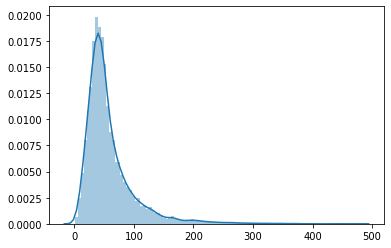

In [9]:
sns.distplot(train.target.values, bins=100)

In [11]:
print(train.shape, test.shape)

(15539, 729) (5035, 729)


In [48]:
# Calculating daily averages
# Each column represents an hourly reading so a daily reading
# would be a collection of 24 feature columns per weather variable

def get_columns(df):
    """
    Fetches individual weather variables for the 
    entire 5-day duration.
    """
    temp = [col for col in df.columns if 'temp' in col]
    precip = [col for col in df.columns if 'precip' in col]
    humid = [col for col in df.columns if 'rel_humidity' in col]
    windir = [col for col in df.columns if 'wind_dir' in col]
    winspd = [col for col in df.columns if 'windspeed' in col]
    at_pres = [col for col in df.columns if 'atm_pressure' in col]
    return temp, precip, humid, windir, winspd, at_pres

temp, precip, humid, windir, winspd, at_pres = get_columns(train)

def gen_daily_means(df):
    """Compute daily individual feature means."""
    for i in range(1,6):
        start, stop = 0, 24
        df[f'day{i}_temp'] = df[temp[start:stop]].mean(axis=1)
        df[f'day{i}_precip'] = df[precip[start:stop]].mean(axis=1)
        df[f'day{i}_humid'] = df[humid[start:stop]].mean(axis=1)
        df[f'day{i}_windir'] = df[windir[start:stop]].mean(axis=1)
        df[f'day{i}_winspd'] = df[winspd[start:stop]].mean(axis=1)
        df[f'day{i}_at_pres'] = df[at_pres[start:stop]].mean(axis=1)
        start = stop
        stop += 24
    #df.drop((temp+precip+humid+windir+winspd+at_pres), axis=1, inplace=True)
    return df

train_aggr = gen_daily_means(train)
test_aggr = gen_daily_means(test)

In [49]:
print(train_aggr.shape, test_aggr.shape)
#train_aggr.to_csv('./proc_data/train_aggr.csv', index=False)
#test_aggr.to_csv('./proc_data/test_aggr.csv', index=False)

(15539, 23) (5035, 23)


In [32]:
#train_aggr.head()

In [7]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [8]:
# Create train and 
y = train.target
X = train.drop(['ID', 'target'], axis=1)

ids = test['ID']
test = test.drop(['ID', 'target'], axis=1)

X = X.fillna(value=X.mean()).astype('float32')
test = test.fillna(value=test.mean()).astype('float32')

In [22]:
# Split the train set into train and validation
X_train = X[:12500]
X_val = X[12500:]
y_train = y[:12500]
y_val = y[12500:]

In [23]:
X_train.shape, X_val.shape, (y_train.shape, y_val.shape)

((12500, 727), (3039, 727), ((12500,), (3039,)))

### Modelling and evaluation

In [21]:
#SVR
group_kfold = GroupKFold(n_splits=5)

groups = np.array(X.location)
train_scores = []
for train, val in group_kfold.split(X, y, groups):
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_val, y_val = X.iloc[val], y.iloc[val]
    
    svr_model = make_pipeline(PolynomialFeatures(),
                              MinMaxScaler(),
                              SVR(kernel='rbf',
                                  C=10,
                                  cache_size=200
                                  )
                             )
    svr_model.fit(X_train, y_train)
    root_mse = rmse(y_val, svr_model.predict(X_val))
    train_scores.append(root_mse)
    print(root_mse)

print("Average score in 5-fold CV:", np.mean(train_scores))

MemoryError: 

In [37]:
# RandomForest
group_kfold = GroupKFold(n_splits=5)

groups = np.array(X.location)
scores = []
for train, val in group_kfold.split(X, y, groups):
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_val, y_val = X.iloc[val], y.iloc[val]
    
    model = RandomForestRegressor(n_estimators=200, max_depth=11, n_jobs=-1, max_features='sqrt',
                                  random_state=42)
    model.fit(X_train, y_train)
    root_mse = rmse(y_val, model.predict(X_val))
    scores.append(root_mse)
    print(root_mse)

print("Average score in 10-fold CV:", np.mean(scores))

33.313880458578275
47.49760567878634
41.032216184650395
44.96394481849733
36.39231413498861
Average score in 10-fold CV: 40.639992255100196


In [28]:
model = RandomForestRegressor(n_estimators=200, max_depth=11, n_jobs=-1, max_features='sqrt',
                              random_state=42)

SVR(C=10, cache_size=50, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [29]:
y_prime = model.predict(X_val)
sq_error = rmse(y_val, y_prime)
sq_error

43.648844971104836

Text(0.5, 0, 'Air Quality')

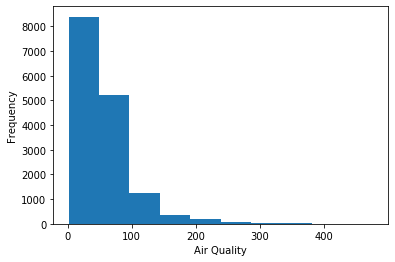

In [81]:
ax = y.plot(kind='hist')
plt.xlabel('Air Quality')

In [30]:
predictions = model.predict(test)

Text(0.5, 0, 'Air Quality')

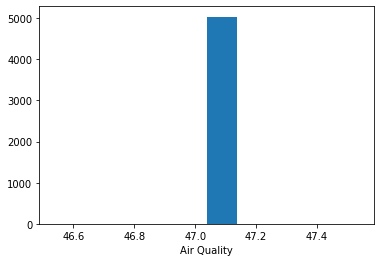

In [31]:
plt.hist(predictions, bins=10)
plt.xlabel('Air Quality')

In [14]:
sample_sub['ID'] = ids
sample_sub['target'] = predictions
sample_sub.head()

,ID,target
0,ID_test_0,47.177368
1,ID_test_1,47.177368
2,ID_test_10,47.177368
3,ID_test_100,47.177368
4,ID_test_1000,47.177368


In [15]:
#sample_sub.to_csv(f"./submissions/submission_rf_{np.round(np.mean(scores), 4)}.csv", index=False)
sample_sub.to_csv(f'./submissions/sub_svr_{np.round(np.mean(train_scores), 4)}.csv', index=False)

In [16]:
#40.6376 (groupkfold) >>>> (best score) md:11.max_features:'sqrt',n_est:200

In [17]:
max(sample_sub.target), min(sample_sub.target)

(47.17736811037563, 47.17736811037563)